# **VGG16 adam with 0.5 dropout 64.74**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
# Paths to your dataset
train_dir = '/content/drive/MyDrive/train'  # Update with your path to training data
test_dir = '/content/drive/MyDrive/test'    # Update with your path to test data

In [ ]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to (224, 224) for VGG16
    batch_size=32,
    class_mode='binary'  # For binary classification
)

Found 4638 images belonging to 2 classes.


In [ ]:
# Flow validation images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1160 images belonging to 2 classes.


In [ ]:
# Load VGG16 with pre-trained ImageNet weights, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
# Combine base model and top layers into new model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze all layers of the base model (only train top layers)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model with Adam optimizer and a learning rate of 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks for learning rate reduction, early stopping, and model checkpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/vgg16_bully_classifier_best.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model on the data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,  # Initial training epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 744ms/step - accuracy: 0.6692 - loss: 0.6995 - val_accuracy: 0.6519 - val_loss: 0.7253 - learning_rate: 1.0000e-07
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6562 - loss: 0.7493 - val_accuracy: 1.0000 - val_loss: 0.4863 - learning_rate: 1.0000e-07
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 742ms/step - accuracy: 0.6843 - loss: 0.6891 - val_accuracy: 0.6528 - val_loss: 0.7250 - learning_rate: 1.0000e-07
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.6875 - loss: 0.6951 - val_accuracy: 1.0000 - val_loss: 0.5125 - learning_rate: 1.0000e-07
Epoch 5/40
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.6619 - loss: 0.7020

In [ ]:
# Unfreeze some of the top layers of the base model for fine-tuning
for layer in base_model.layers[-100:]:  # Unfreeze the last 50 layers
    layer.trainable = True

In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
optimizer_fine = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_fine, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training the model for fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,  # Additional fine-tuning epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5842 - loss: 0.7863 - val_accuracy: 0.6137 - val_loss: 0.7561 - learning_rate: 1.0000e-05
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.5938 - loss: 0.7466 - val_accuracy: 0.5000 - val_loss: 0.7549 - learning_rate: 1.0000e-05
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 743ms/step - accuracy: 0.6103 - loss: 0.7597 - val_accuracy: 0.6311 - val_loss: 0.7499 - learning_rate: 1.0000e-05
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7812 - loss: 0.6689 - val_accuracy: 0.7500 - val_loss: 0.6637 - learning_rate: 1.0000e-05
Epoch 5/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 111s 740ms/step - accuracy: 0.6139 - loss: 0.7501 - val_accuracy: 0.6215 - val_loss: 0.7414 - learning_rate: 1.0000e-05
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5938 - loss: 0.7748 - val_accuracy: 0.7500 - val_loss: 0.6512 - learning_rate: 1.0000e-05
Epoch 7/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 140s 743ms/s

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.5728 - loss: 0.7952
Test accuracy: 0.5698275566101074


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6359 - loss: 0.7327
Test accuracy: 0.6474137902259827


In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
print(f'Train accuracy: {train_acc}')

145/145 ━━━━━━━━━━━━━━━━━━━━ 87s 596ms/step - accuracy: 0.6835 - loss: 0.6974
Train accuracy: 0.6849935054779053


In [ ]:
# Save the fine-tuned model
model.save('/content/drive/MyDrive/FINAL VGG16.keras')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
model_path = '/content/drive/MyDrive/FINAL VGG16.keras'
model = tf.keras.models.load_model(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.6440 - loss: 0.7317
Test accuracy: 0.6474137902259827


# **Prediction**

In [ ]:
print(train_generator.class_indices)

{'bully': 0, 'nonbully': 1}


In [ ]:
# Function to load and preprocess the image   #4622
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # VGG16 expects 224x224 images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image to [0, 1] range
    return img_array

# Path to your image
img_path = '/content/drive/MyDrive/test/nonbully/2415.jpg'  # Update with the path to your image

# Preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make prediction
prediction = model.predict(img_array)

# Interpret the result
if prediction[0] < 0.5:
    print("Predicted: Bully")
else:
    print("Predicted: Non-Bully")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: Non-Bully


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 272s 7s/step
Classification Report:
              precision    recall  f1-score   support

       bully       0.58      0.51      0.54       639
    nonbully       0.47      0.54      0.50       521

    accuracy                           0.52      1160
   macro avg       0.52      0.52      0.52      1160
weighted avg       0.53      0.52      0.52      1160



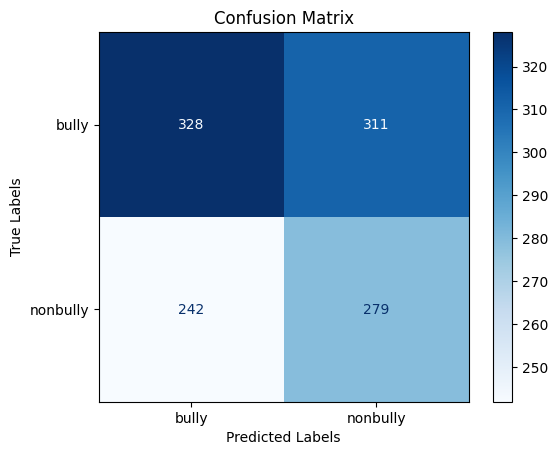

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf

# Load the saved model
model_path = '/content/drive/MyDrive/FINAL VGG16.keras'
model = tf.keras.models.load_model(model_path)

# Ensure the test generator is defined (as in your code)
test_generator.reset()  # Reset generator to align predictions with labels

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cmd.plot(cmap='Blues', values_format='d')
cmd.ax_.set_title('Confusion Matrix')
cmd.ax_.set_xlabel('Predicted Labels')
cmd.ax_.set_ylabel('True Labels')

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
